# Answers to the homework, as python functions and comments

Note that most of the provided files had a few tweaks for debugging or standardizing data types (e.g. device is forced to be CPU). Running the training/eval will likely require this copy of all files, rather than previously provided ones


In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np

from dataset import Dataset

ENV_NAME = 'CartPole-v0'
dataset = Dataset(data_path="{}_dataset.pkl".format(ENV_NAME))

In [2]:
# Given a history of observed states, plot historgrams for what values were observed along each dimension
def _viewStatesHist(obsStates):
    f, axes = plt.subplots(1, 4, figsize=(16, 6))
    f.suptitle("Observed states:")
    for i, (ax, title) in enumerate(zip(axes, ["x", "v", "θ", "ω"])):
        ax.hist(obsStates[:, i], log=True, bins=20)
        ax.set_title(title)
    plt.show()
    # Also print min & max values, to calculate ranges:
    print ("Mins: ", np.min(obsStates, axis=0))
    print ("Maxs: ", np.max(obsStates, axis=0))

# 1: Behavioural cloning

### Q1.1 Dataset

99660 state/action pairs in the dataset


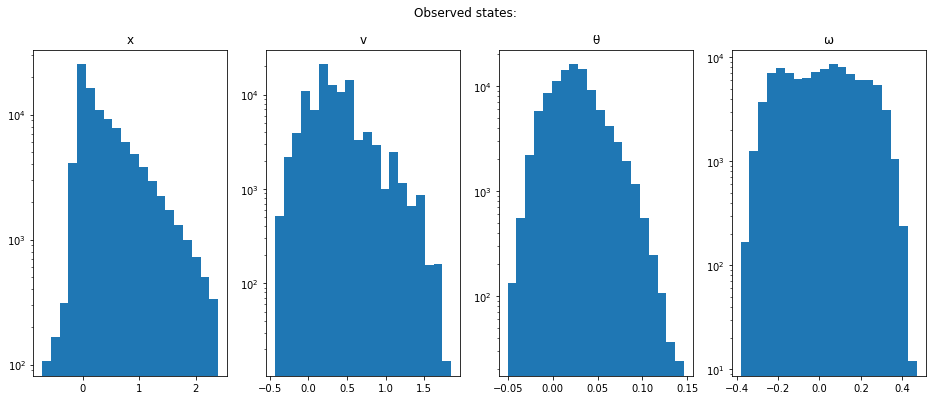

Mins:  [-0.72267057 -0.43303689 -0.05007198 -0.38122098]
Maxs:  [2.39948596 1.84697975 0.14641718 0.47143314]

Action 0 used 48555 times (48.72%), Action 1 used 51105 (51.28%)


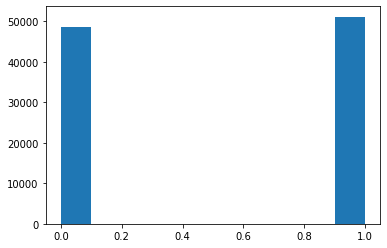

In [10]:
def a_1_1():
    # How big is the dataset provided? 99660 state/action examples
    n = len(dataset)
    print ("%d state/action pairs in the dataset" % n)

    states = np.zeros((len(dataset), 4))
    actions = np.zeros((len(dataset), 1))
    for i, data in enumerate(dataset):
        states[i] = data['state']
        actions[i] = data['action']
        
    # What are the dimensionalities and ranges of the state in the dataset 
    # (how much of the state space does the expert data cover)?
    # 4D state, see histograms for converage of all the values.
    _viewStatesHist(states)
    
    # 48.72% action 0, 51.28%
    n0 = np.sum(actions == 0)
    print ("\nAction 0 used %d times (%.2f%%), Action 1 used %d (%.2f%%)" % (n0, 100 * (n0 / n), (n - n0), 100 * (n - n0) / n))
    plt.hist(actions)
    plt.show()
    
a_1_1()

### Q1.2 Environment

_Considering the full state and action spaces, do you think our expert dataset has good coverage? Why or why not? How might this affect or not affect the performance of our cloned policy?_

The range is much smaller - x is mostly only positive, and the remainder have a much narrower range than allowed values (see a3 answers). Note that positive x isn't much of a problem as the environment is symmetric, so the dataset can be augmented by negating the entire state and flipping the action, however this would still not cover the more extreme cases. That said, as the environment is deterministic, a good clone can probably avoid having to get into the extreme values

### Q1.3 Model

_What is the input of the network?_  
A Bx4 tensor of floats, representing a batch of state values

_What is the output?_  
A Bx2 tensor of floats, representing which of the 2 actions should be taken.  
To convert to an action, take the index of the highest value, as higher values represented more confidence that a given action should be taken.

The selected network is simple fully connected network with one hidden layer, of dimension 10.

## Q1.4 Training

_Initializing the model_  
Uses pytorch's default initialization: uniform random based on the model size.

_Choosing a loss function_  
CrossEntropyLoss is used - as the expert policy only picks a single action each time, we use cross entropy loss to better compare the distance between predicted (action 0, action 1) values, and the final picked (1, 0) or (0, 1)

_Choosing an optimizer_  
I picked the Adam optimizer, with learning rate 1e-4, simply because it seems an okay default and it worked, so no further tweaking was required.

_Playing with hyperparameters to train your model._  
Learning rate 1e-4 converted in about 20 epochs, increasing it (e.g. 1e-2) converged within the first few epochs, yet took some time to reach a consistent 200.0 score. Eventually 1e-3 was used, providing a balance between the two.

_Did you manage to learn a good policy? How consistent is the reward you are getting?_  
A model provided `behavioral_cloning_CartPole-v0.pt` consistently scored 200.0  


# Task 2: Deep Q Learning

### 2.0 Think about your model...

_These two outputs, though, represent very different things. What is each one representing?_  
In the case of behavioural cloning, the values are unit-free, passed through a softmax so (roughly) represent the probability/confidence in each action being the best, once normalized by the value of the other actions.  
In the case of the deep Q network, the two values of the output are intended to exactly represent the Q values, i.e. the future (discounted) reward of performing each action given the state.

### 2.1 Update your Q-function

Updates can be seen in `optimize_model` within `dqn.py` - $y_i$ and $Q(\phi_j, a_j; \theta_j)$ are calculated using the provided equations, and the loss to minimize is set to the mean squared error of their distance.


### 2.2 $\epsilon$-greedy strategy

Implemented in `choose_action` within `dqn.py`

### 2.3 Train your model

The initial model does not seem to train very well - initially it appears to get stuck in a situation where it very quickly terminates, but predicts these reward values very well. Increasing $\epsilon$ helps it explore more states faster, but prediction of Q remains bad due to lack of training exapmles.

### 2.4 Add the Experience Replay Buffer

A version of `optimize_model` was added that uses batch updates based on history (when `USE_MEMORY = True`). This performs much better - after some tweaking of learning rate, a buffer size of 256 can be used to achieve average reward in the order of 50-100 after 4000 steps.

# Task 3: Extra

Double DQN was implemented, using the `target` model that is copied from the updated model every `TARGET_UPDATE` episodes. By using this within `optimize_model`, the updates are stabilized a bit better.

The algorithm appears very sensitive to learning rate, but by putting it conservatively lower, convergence to a maxed 200 reward is possible.

Provided at `best_model_CartPole-v0.pt` in the zip is one example achieved of a final model that averges 200